## Deep Learning Project

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.utils import save_image

## Preparing the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -u "/content/drive/MyDrive/DeepLearning/data/art.zip" -d "/content/drive/MyDrive/DeepLearning/data/art"

Archive:  /content/drive/MyDrive/DeepLearning/data/art.zip
  inflating: /content/drive/MyDrive/DeepLearning/data/art/Abstract_gallery/Abstract_gallery/Abstract_image_0.jpg  
  inflating: /content/drive/MyDrive/DeepLearning/data/art/Abstract_gallery/Abstract_gallery/Abstract_image_1.jpg  
  inflating: /content/drive/MyDrive/DeepLearning/data/art/Abstract_gallery/Abstract_gallery/Abstract_image_10.jpg  
  inflating: /content/drive/MyDrive/DeepLearning/data/art/Abstract_gallery/Abstract_gallery/Abstract_image_100.jpg  
  inflating: /content/drive/MyDrive/DeepLearning/data/art/Abstract_gallery/Abstract_gallery/Abstract_image_1000.jpg  
  inflating: /content/drive/MyDrive/DeepLearning/data/art/Abstract_gallery/Abstract_gallery/Abstract_image_1001.jpg  
  inflating: /content/drive/MyDrive/DeepLearning/data/art/Abstract_gallery/Abstract_gallery/Abstract_image_1002.jpg  
  inflating: /content/drive/MyDrive/DeepLearning/data/art/Abstract_gallery/Abstract_gallery/Abstract_image_1003.jpg  
  infl

In [ ]:
DATA_DIR = "/content/drive/MyDrive/DeepLearning/data/art"

In [ ]:
stats = (.5, .5, .5), (.5, .5, .5)

In [ ]:
transform_ds = T.Compose([
    T.Resize((128, 128)),
    T.CenterCrop(128),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize(*stats)
])
ds = torchvision.datasets.ImageFolder(root=DATA_DIR, transform=transform_ds)

In [ ]:
def denorm(img_tensor):
    return img_tensor * stats[1][0] + stats[0][0]

In [ ]:
batch_size=128

In [ ]:
train_dl = DataLoader(ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


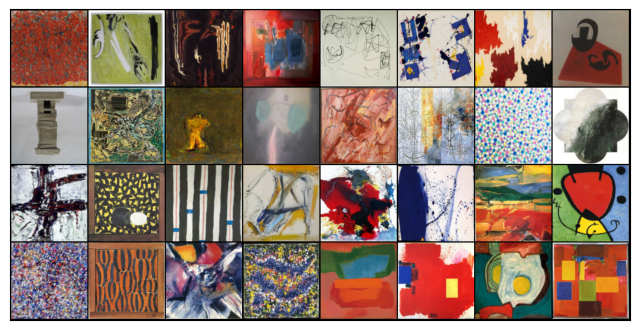

In [ ]:
def show_image(train_dl):
    for images,_ in train_dl:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(images.detach()[:32]), nrow=8).permute(1,2,0))
        break

show_image(train_dl)

## Moving to the GPU

In [ ]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)

    def __len__(self):
        return len(self.dl)

device = get_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
discriminator = nn.Sequential(
    #in: 128 x 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 512 x 8 x 8

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 1024 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    #128 x 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()

)

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size=128

In [ ]:
generator = nn.Sequential(
    #in: 128 x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    #128 x 1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #128 x 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #128 x 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #128 x 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #128 x 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    #128 x 3 x 128 x 128
    nn.Tanh()


)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    real_preds= discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    latent = torch.randn(latent_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    fake_preds= discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward(),
    opt_d.step()

    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    opt_g.zero_grad()

    latent = torch.randn(latent_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    preds = discriminator(fake_images)
    targets = torch.ones(fake_images.size(0), 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    loss.backward(),
    opt_g.step()

    return loss.item()

In [ ]:
sample_dir = "generated"
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_sample(index, fixed_latent, show=True):
    fake_images = generator(fixed_latent)
    fake_fname = "generated-images-{0:0=4d}.png".format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach()[:32], nrow=8).permute(1,2,0))

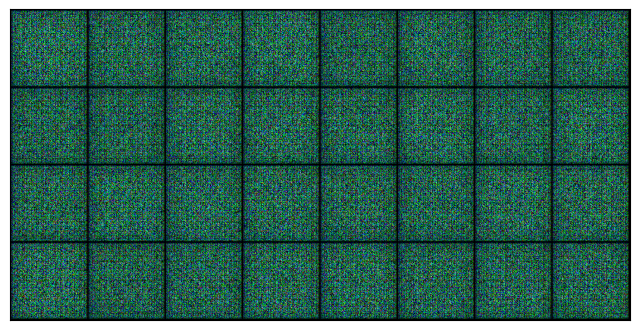

In [ ]:
fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)
save_sample(0, fixed_latent, show=True)

In [ ]:
def fit(epochs, lr_d, lr_g, start_idx=1):
    torch.cuda.empty_cache()

    losses_d = []
    losses_g = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images,_ in tqdm(train_dl):
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)

        losses_d.append(loss_d)
        losses_g.append(loss_g)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch: [{}/{}], loss_d: {:.4f}, loss_g: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_d, loss_g, real_score, fake_score))

        save_sample(epoch+start_idx, fixed_latent, show=False)

    return losses_d, losses_g, real_scores, fake_scores

In [ ]:
epochs = 20
lr_d = 10e-5
lr_g = 10e-4

In [ ]:
history = [fit(epochs, lr_d, lr_g, start_idx=1)]

  0%|          | 0/23 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: [1/20], loss_d: 1.6200, loss_g: 4.4563, real_score: 0.5199, fake_score: 0.5413


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [2/20], loss_d: 1.6059, loss_g: 2.3090, real_score: 0.4564, fake_score: 0.5140


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [3/20], loss_d: 1.0013, loss_g: 2.6111, real_score: 0.6211, fake_score: 0.3846


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [4/20], loss_d: 0.8627, loss_g: 2.0301, real_score: 0.5599, fake_score: 0.2127


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [5/20], loss_d: 0.2018, loss_g: 3.7260, real_score: 0.8903, fake_score: 0.0788


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [6/20], loss_d: 0.4929, loss_g: 5.3909, real_score: 0.6582, fake_score: 0.0430


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [7/20], loss_d: 0.2936, loss_g: 5.1727, real_score: 0.9544, fake_score: 0.2149


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [8/20], loss_d: 0.0725, loss_g: 4.6661, real_score: 0.9581, fake_score: 0.0281


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [9/20], loss_d: 0.0332, loss_g: 6.5386, real_score: 0.9697, fake_score: 0.0021


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [10/20], loss_d: 0.9106, loss_g: 18.1271, real_score: 0.5061, fake_score: 0.0000


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [11/20], loss_d: 0.0188, loss_g: 8.2723, real_score: 0.9820, fake_score: 0.0005


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [12/20], loss_d: 0.0142, loss_g: 7.1547, real_score: 0.9873, fake_score: 0.0013


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [13/20], loss_d: 0.0121, loss_g: 5.6422, real_score: 0.9939, fake_score: 0.0059


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [14/20], loss_d: 0.1593, loss_g: 9.0442, real_score: 0.8638, fake_score: 0.0001


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [15/20], loss_d: 0.0863, loss_g: 9.1279, real_score: 0.9261, fake_score: 0.0005


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [16/20], loss_d: 0.0893, loss_g: 8.9633, real_score: 0.9905, fake_score: 0.0765


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [17/20], loss_d: 0.0655, loss_g: 7.7129, real_score: 0.9921, fake_score: 0.0559


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [18/20], loss_d: 0.0176, loss_g: 7.4941, real_score: 0.9849, fake_score: 0.0004


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [19/20], loss_d: 0.0726, loss_g: 9.4835, real_score: 0.9947, fake_score: 0.0650


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: [20/20], loss_d: 0.0207, loss_g: 7.6974, real_score: 0.9805, fake_score: 0.0008


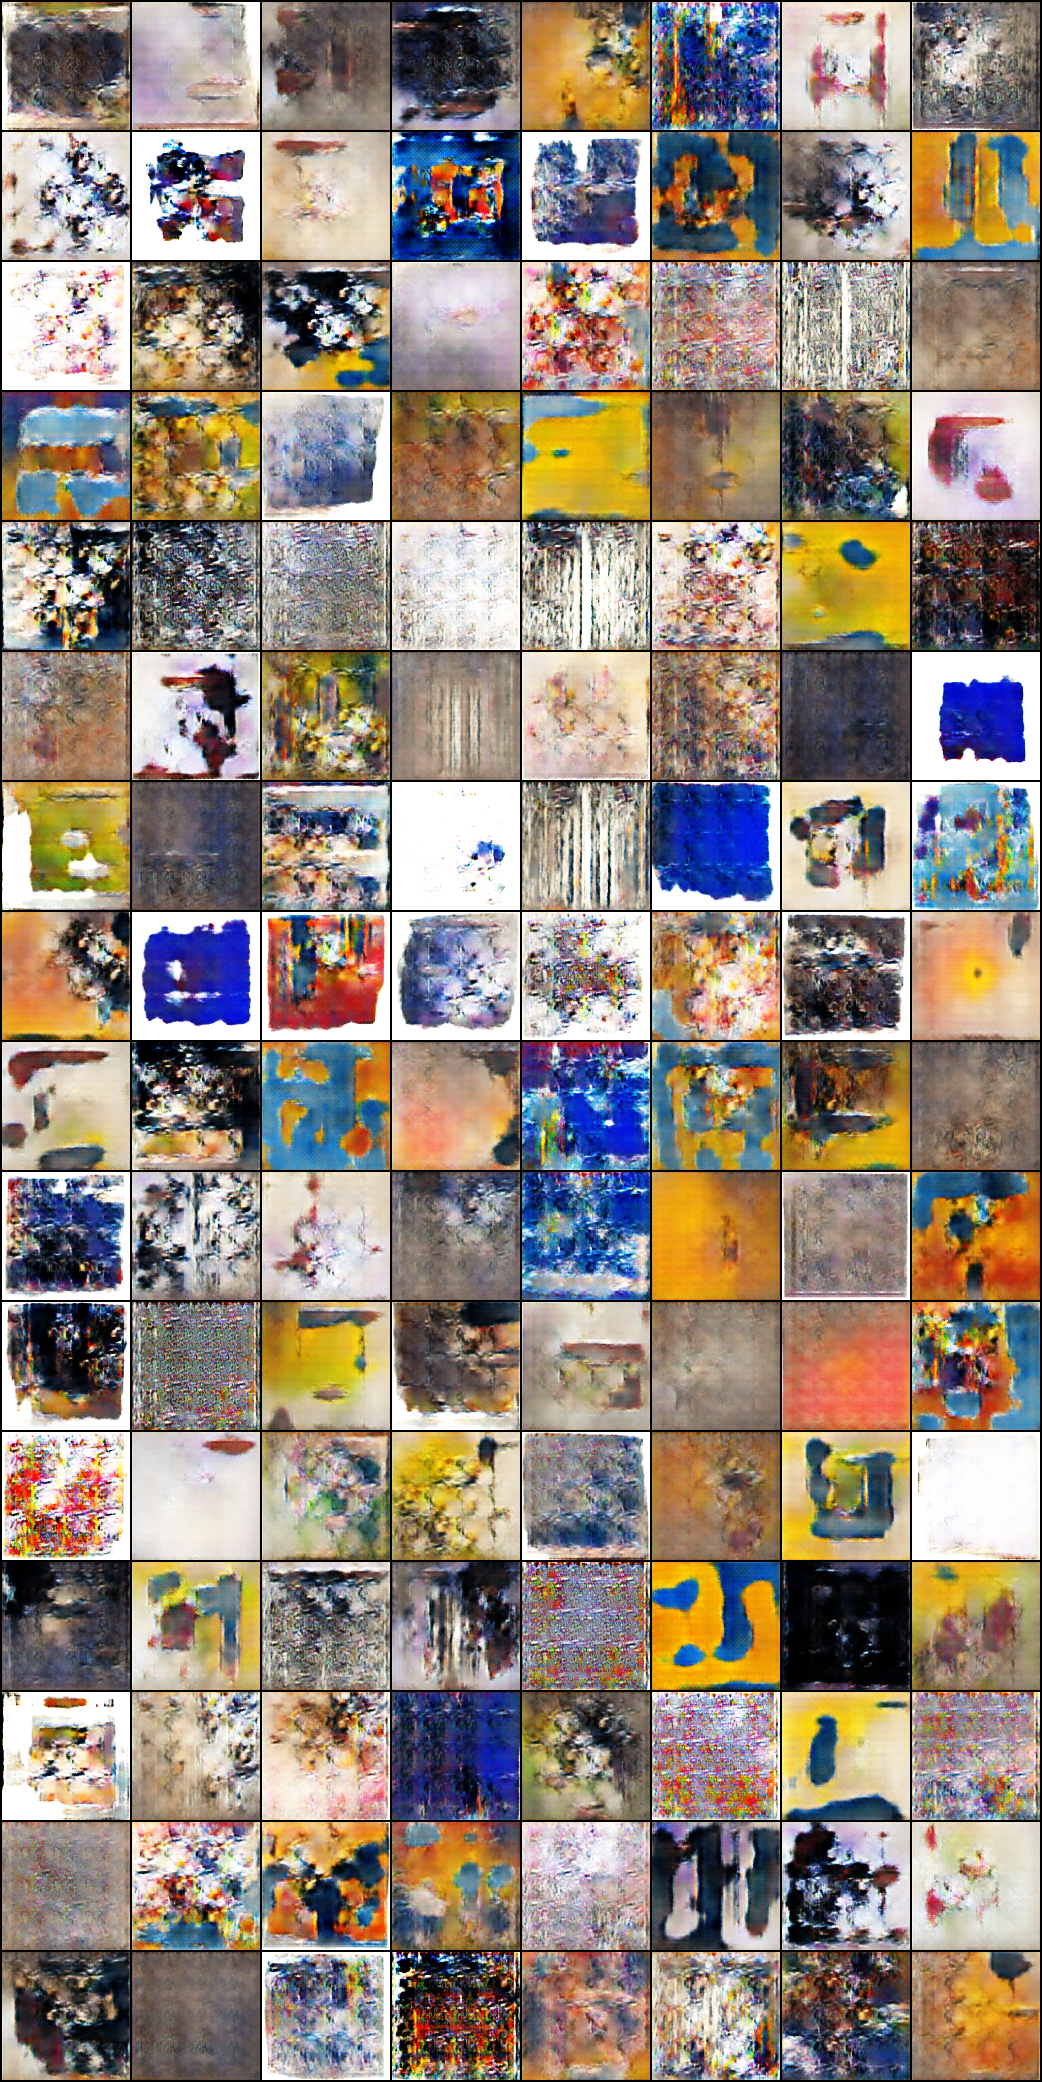

In [ ]:
Image("/content/generated/generated-images-0200.png")